# Daily Market Update Testing Notebook

This notebook provides a testing ground for the daily market update pipeline components. It allows you to:

1. Load test data (from pickle files)
2. Process the data through each component of the pipeline
3. Visualize and validate the transformed data before saving to Supabase

## Setup Environment

In [1]:
# Import required modules
import sys
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date, datetime, timedelta
from pprint import pprint
import json

# Add the project root to path so we can import modules
# Adjust this path if notebook is not in the project root
sys.path.append(os.path.abspath('./'))

# Import project modules
from src.models.source_models import YFTickerData
from src.models.db_models import DBHistoricalPrice, DBTickerInfo, DBFinanceDaily, DBCalendarEvent
from src.transformers.model_transformer import ModelTransformer
from src.services.data_fetcher import DataFetcher
from src.services.data_saver import DataSaver
from src.services.ticker_processor import TickerProcessor

# Set up plotting
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)

## Load Test Data

We'll use the pickle files created by the `fetch_yfinance_data.py` script.

In [2]:
def load_test_data(filename):
    """Load test data from pickle file"""
    with open(f"tests/{filename}", "rb") as f:
        data = pickle.load(f)
    return data

# Load test data for AAPL (equity) and SPY (ETF)
try:
    aapl_data = load_test_data("aapl_yfinance_data.pkl")
    spy_data = load_test_data("spy_yfinance_data.pkl")
    print("Successfully loaded test data.")
except FileNotFoundError:
    print("Test data files not found. Please run fetch_yfinance_data.py first.")
    # Optionally, run the fetch script directly
    # %run fetch_yfinance_data.py

Successfully loaded test data.


## Explore Raw Data Structure

Let's look at the structure of the test data to understand what we're working with.

In [3]:
# Examine AAPL data structure
print("AAPL data keys:", list(aapl_data.keys()))
print("\nHistorical data shape:", aapl_data["history"].shape)
print("\nSample of historical data:")
display(aapl_data["history"].head())

print("\nInfo keys:")
info_keys = list(aapl_data["info"].keys())
print(f"Total keys: {len(info_keys)}")
# Display first 20 keys for brevity
pprint(info_keys[:20])

print("\nCalendar data:")
pprint(aapl_data["calendar"])

AAPL data keys: ['history', 'info', 'calendar', 'funds_data']

Historical data shape: (20, 7)

Sample of historical data:


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-02-18 00:00:00-05:00,244.149994,245.179993,241.839996,244.470001,48822500,0.0,0.0
2025-02-19 00:00:00-05:00,244.660004,246.009995,243.160004,244.869995,32204200,0.0,0.0
2025-02-20 00:00:00-05:00,244.940002,246.779999,244.289993,245.830002,32316900,0.0,0.0
2025-02-21 00:00:00-05:00,245.949997,248.690002,245.220001,245.550003,53197400,0.0,0.0
2025-02-24 00:00:00-05:00,244.929993,248.860001,244.419998,247.100006,51326400,0.0,0.0



Info keys:
Total keys: 180
['address1',
 'city',
 'state',
 'zip',
 'country',
 'phone',
 'website',
 'industry',
 'industryKey',
 'industryDisp',
 'sector',
 'sectorKey',
 'sectorDisp',
 'longBusinessSummary',
 'fullTimeEmployees',
 'companyOfficers',
 'auditRisk',
 'boardRisk',
 'compensationRisk',
 'shareHolderRightsRisk']

Calendar data:
{'Dividend Date': datetime.date(2025, 2, 12),
 'Earnings Average': 1.61684,
 'Earnings Date': [datetime.date(2025, 4, 30), datetime.date(2025, 5, 5)],
 'Earnings High': 1.67,
 'Earnings Low': 1.5,
 'Ex-Dividend Date': datetime.date(2025, 2, 9),
 'Revenue Average': 94058321570,
 'Revenue High': 95903397000,
 'Revenue Low': 89370000000}


In [4]:
# Examine SPY ETF data (with fund-specific data)
print("SPY data keys:", list(spy_data.keys()))

# Check if fund_data exists and is not None
if spy_data.get("funds_data") is not None:
    print("\nFund data keys:")
    pprint(list(spy_data["funds_data"].keys()))
    
    # Examine top holdings if available
    if "top_holdings" in spy_data["funds_data"] and spy_data["funds_data"]["top_holdings"] is not None:
        print("\nTop holdings:")
        display(spy_data["funds_data"]["top_holdings"].head())
    
    # Look at sector weightings
    if "sector_weightings" in spy_data["funds_data"] and spy_data["funds_data"]["sector_weightings"] is not None:
        print("\nSector weightings:")
        pprint(spy_data["funds_data"]["sector_weightings"])
else:
    print("No fund data available for SPY")

SPY data keys: ['history', 'info', 'calendar', 'funds_data']

Fund data keys:
['description',
 'fund_overview',
 'fund_operations',
 'asset_classes',
 'top_holdings',
 'equity_holdings',
 'bond_holdings',
 'bond_ratings',
 'sector_weightings']

Top holdings:


,Name,Holding Percent
Symbol,,
AAPL,Apple Inc,0.072364
NVDA,NVIDIA Corp,0.060659
MSFT,Microsoft Corp,0.058428
AMZN,Amazon.com Inc,0.039326
META,Meta Platforms Inc Class A,0.028836



Sector weightings:
{'basic_materials': 0.0175,
 'communication_services': 0.0945,
 'consumer_cyclical': 0.106800005,
 'consumer_defensive': 0.0587,
 'energy': 0.033,
 'financial_services': 0.14050001,
 'healthcare': 0.1078,
 'industrials': 0.0733,
 'realestate': 0.0219,
 'technology': 0.32029998,
 'utilities': 0.0257}


## Test Data Transformation

Now let's test the data transformation process by manually transforming the test data using our `ModelTransformer` class.

In [5]:
# Create mock ticker data
def create_mock_ticker_data(raw_data, symbol, exchange="NASDAQ"):
    """Create a YFTickerData instance from raw test data"""
    # Create a mock ticker object with the necessary data
    class MockTicker:
        def __init__(self, raw_data):
            self.info = raw_data["info"]
            self.history = raw_data["history"]
            self.calendar = raw_data["calendar"]
            self.symbol = symbol
            
            # Add funds_data for ETFs
            if raw_data.get("funds_data") is not None:
                class FundsData:
                    pass
                self.funds_data = FundsData()
                for key, value in raw_data["funds_data"].items():
                    if value is not None:
                        setattr(self.funds_data, key, value)
    
    mock_ticker = MockTicker(raw_data)
    
    # Use the YFTickerData.from_yfinance factory method
    ticker_data = YFTickerData.from_yfinance(mock_ticker, symbol, exchange)
    
    return ticker_data

# Create transformer
transformer = ModelTransformer()

# Create ticker IDs (in a real scenario, these would come from your database)
aapl_ticker_id = "aapl-test-id"
spy_ticker_id = "spy-test-id"

In [6]:
# Create YFTickerData objects from test data
aapl_ticker_data = create_mock_ticker_data(aapl_data, "AAPL", "NASDAQ")
spy_ticker_data = create_mock_ticker_data(spy_data, "SPY", "NYSE")

# Print basic info from the parsed data
print(f"AAPL Quote Type: {aapl_ticker_data.info.quote_type}")
print(f"SPY Quote Type: {spy_ticker_data.info.quote_type}")

# Check if price history is available
if aapl_ticker_data.price_history:
    print(f"AAPL price points: {len(aapl_ticker_data.price_history.data)}")
    
if spy_ticker_data.price_history:
    print(f"SPY price points: {len(spy_ticker_data.price_history.data)}")

AAPL Quote Type: YFQuoteType.EQUITY
SPY Quote Type: YFQuoteType.ETF
AAPL price points: 20
SPY price points: 20


### Transform Historical Prices

AAPL price records: 20
SPY price records: 20


,ticker_id,date,open_price,high_price,low_price,close_price,dividends,stock_splits,volume,created_at,updated_at
0,aapl-test-id,2025-02-18,244.149994,245.179993,241.839996,244.470001,0.0,0.0,48822500,None,2025-04-13T19:03:54.669434
1,aapl-test-id,2025-02-19,244.660004,246.009995,243.160004,244.869995,0.0,0.0,32204200,None,2025-04-13T19:03:54.669450
2,aapl-test-id,2025-02-20,244.940002,246.779999,244.289993,245.830002,0.0,0.0,32316900,None,2025-04-13T19:03:54.669458
3,aapl-test-id,2025-02-21,245.949997,248.690002,245.220001,245.550003,0.0,0.0,53197400,None,2025-04-13T19:03:54.669465
4,aapl-test-id,2025-02-24,244.929993,248.860001,244.419998,247.100006,0.0,0.0,51326400,None,2025-04-13T19:03:54.669471


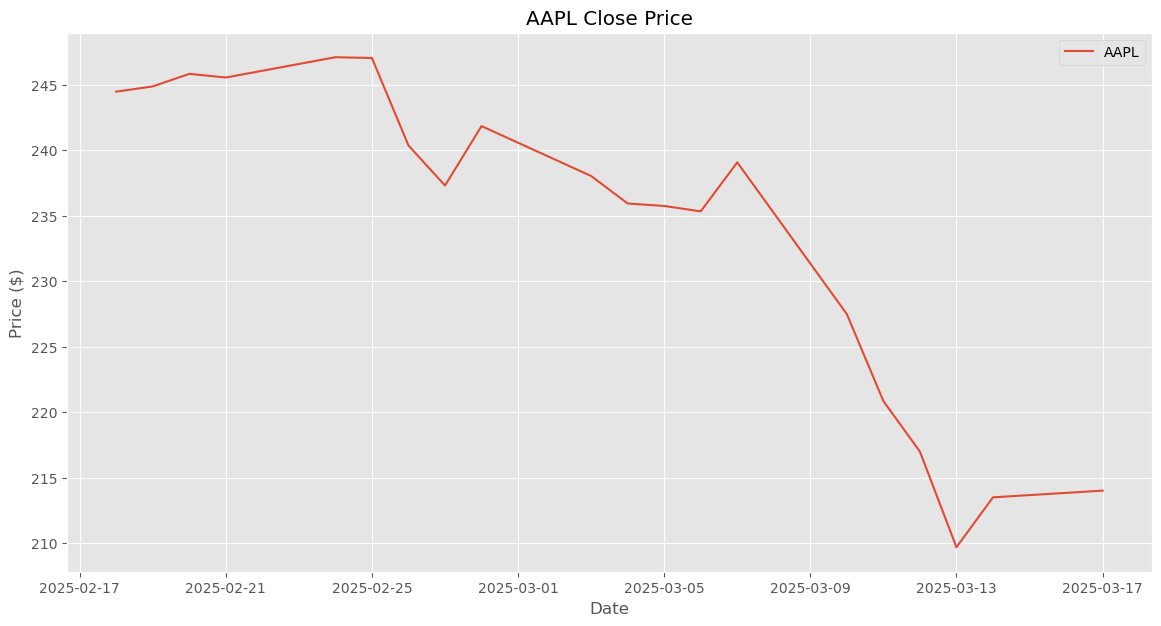

In [7]:
# Transform historical prices
aapl_prices = transformer.transform_historical_prices(aapl_ticker_data.price_history, aapl_ticker_id)
spy_prices = transformer.transform_historical_prices(spy_ticker_data.price_history, spy_ticker_id)

# Display sample of transformed prices
print(f"AAPL price records: {len(aapl_prices)}")
print(f"SPY price records: {len(spy_prices)}")

# Create DataFrame for easier viewing
def db_prices_to_df(prices):
    return pd.DataFrame([p.model_dump() for p in prices])

aapl_prices_df = db_prices_to_df(aapl_prices)
display(aapl_prices_df.head())

# Plot the closing prices
plt.figure(figsize=(14, 7))
plt.plot(pd.to_datetime(aapl_prices_df['date']), aapl_prices_df['close_price'], label='AAPL')
plt.title('AAPL Close Price')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()

### Transform Ticker Info and Finance Daily Data

In [8]:
# Transform ticker info
aapl_info = transformer.transform_ticker_info(aapl_ticker_data.info, aapl_ticker_id)
spy_info = transformer.transform_ticker_info(spy_ticker_data.info, spy_ticker_id)

# Display the transformed ticker info
print("AAPL Ticker Info:")
pprint(aapl_info.model_dump())

print("\nSPY Ticker Info:")
pprint(spy_info.model_dump())

AAPL Ticker Info:
{'backfill': False,
 'category': None,
 'cik': None,
 'created_at': None,
 'dividend_amount': 0.25,
 'dividend_months': None,
 'exchange': 'NMS',
 'id': 'aapl-test-id',
 'industry_id': None,
 'long_business_summary': 'Apple Inc. designs, manufactures, and markets '
                          'smartphones, personal computers, tablets, '
                          'wearables, and accessories worldwide. The company '
                          'offers iPhone, a line of smartphones; Mac, a line '
                          'of personal computers; iPad, a line of '
                          'multi-purpose tablets; and wearables, home, and '
                          'accessories comprising AirPods, Apple TV, Apple '
                          'Watch, Beats products, and HomePod. It also '
                          'provides AppleCare support and cloud services; and '
                          'operates various platforms, including the App Store '
                          'that

In [9]:
# Transform finance daily data
aapl_finance = transformer.transform_finance_daily(aapl_ticker_data.info, aapl_ticker_id)
spy_finance = transformer.transform_finance_daily(spy_ticker_data.info, spy_ticker_id)

# Display the transformed finance data
print("AAPL Finance Data:")
aapl_finance_dict = aapl_finance.model_dump()
# Filter out None values for cleaner display
aapl_finance_filtered = {k: v for k, v in aapl_finance_dict.items() if v is not None}
pprint(aapl_finance_filtered)

print("\nSPY Finance Data:")
spy_finance_dict = spy_finance.model_dump()
# Filter out None values for cleaner display
spy_finance_filtered = {k: v for k, v in spy_finance_dict.items() if v is not None}
pprint(spy_finance_filtered)

AAPL Finance Data:
{'beta': 1.178,
 'beta3year': 1.178,
 'date': '2025-04-13',
 'dividend_yield': 0.47,
 'fifty_day_average': 233.5782,
 'fifty_two_week_high': 260.1,
 'fifty_two_week_low': 164.08,
 'market_cap': 3195050655744,
 'regular_market_change_percent': -0.6121484,
 'regular_market_price': 212.69,
 'regular_market_volume': 41207689,
 'shares_outstanding': 15022100480,
 'ticker_id': 'aapl-test-id',
 'trailing_pe': 33.760315,
 'two_hundred_day_average': 228.00475,
 'updated_at': '2025-04-13T19:03:54.870786'}

SPY Finance Data:
{'date': '2025-04-13',
 'dividend_yield': 1.19,
 'fifty_day_average': 591.7026,
 'fifty_two_week_high': 613.23,
 'fifty_two_week_low': 493.86,
 'five_year_average_return': 0.19346741,
 'fund_family': 'SPDR State Street Global Advisors',
 'fund_inception_date': '1993-01-21',
 'legal_type': 'Exchange Traded Fund',
 'market_cap': 514894069760,
 'nav_price': 566.8267,
 'net_expense_ratio': 0.0945,
 'regular_market_change_percent': -1.08084,
 'regular_market_pri

### Transform Calendar Events

In [10]:
# Transform calendar events
aapl_events = transformer.transform_calendar_events(aapl_ticker_data.calendar, aapl_ticker_id)
spy_events = transformer.transform_calendar_events(spy_ticker_data.calendar, spy_ticker_id)

# Display the transformed events
print(f"AAPL Calendar Events: {len(aapl_events)}")
for event in aapl_events:
    print(f"\nEvent Type: {event.event_type}, Date: {event.date}")
    event_dict = event.model_dump()
    # Filter out None values for cleaner display
    event_filtered = {k: v for k, v in event_dict.items() if v is not None}
    pprint(event_filtered)

print(f"\nSPY Calendar Events: {len(spy_events)}")
for event in spy_events:
    print(f"\nEvent Type: {event.event_type}, Date: {event.date}")
    event_dict = event.model_dump()
    # Filter out None values for cleaner display
    event_filtered = {k: v for k, v in event_dict.items() if v is not None}
    pprint(event_filtered)

AAPL Calendar Events: 3

Event Type: DBEventType.DIVIDEND, Date: 2025-02-12
{'date': '2025-02-12',
 'event_type': <DBEventType.DIVIDEND: 'dividend'>,
 'ticker_id': 'aapl-test-id',
 'updated_at': '2025-04-13T19:03:54.902130'}

Event Type: DBEventType.EX_DIVIDEND, Date: 2025-02-09
{'date': '2025-02-09',
 'event_type': <DBEventType.EX_DIVIDEND: 'ex_dividend'>,
 'ticker_id': 'aapl-test-id',
 'updated_at': '2025-04-13T19:03:54.902145'}

Event Type: DBEventType.EARNINGS, Date: 2025-04-30
{'date': '2025-04-30',
 'earnings_average': 1.61684,
 'earnings_dates': ['2025-04-30', '2025-05-05'],
 'earnings_high': 1.67,
 'earnings_low': 1.5,
 'event_type': <DBEventType.EARNINGS: 'earnings'>,
 'revenue_average': 94058321570,
 'revenue_high': 95903397000,
 'revenue_low': 89370000000,
 'ticker_id': 'aapl-test-id',
 'updated_at': '2025-04-13T19:03:54.902163'}

SPY Calendar Events: 0


### Transform Fund Data (for ETFs)

SPY Fund Holdings:
Top Holdings: 10


,id,ticker_id,holding_symbol,holding_name,weight,date,created_at,updated_at
0,None,spy-test-id,AAPL,Apple Inc,0.0,2025-04-13,None,2025-04-13T19:03:54.936169
1,None,spy-test-id,NVDA,NVIDIA Corp,0.0,2025-04-13,None,2025-04-13T19:03:54.936182
2,None,spy-test-id,MSFT,Microsoft Corp,0.0,2025-04-13,None,2025-04-13T19:03:54.936186
3,None,spy-test-id,AMZN,Amazon.com Inc,0.0,2025-04-13,None,2025-04-13T19:03:54.936189
4,None,spy-test-id,META,Meta Platforms Inc Class A,0.0,2025-04-13,None,2025-04-13T19:03:54.936191


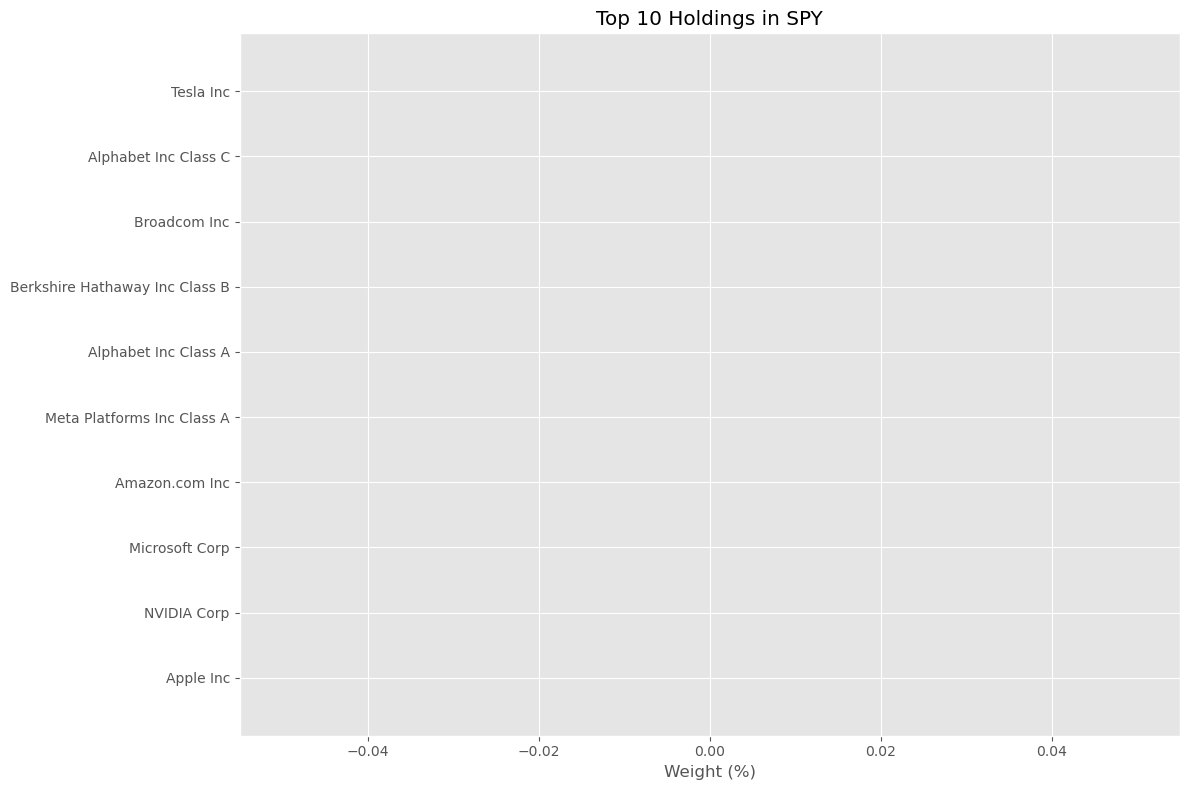


Sector Weightings: 11


,id,ticker_id,sector_name,weight,date,created_at,updated_at
0,None,spy-test-id,realestate,2.190000,2025-04-13,None,2025-04-13T19:03:54.936213
1,None,spy-test-id,consumer-cyclical,10.680001,2025-04-13,None,2025-04-13T19:03:54.936217
2,None,spy-test-id,basic-materials,1.750000,2025-04-13,None,2025-04-13T19:03:54.936219
3,None,spy-test-id,consumer-defensive,5.870000,2025-04-13,None,2025-04-13T19:03:54.936223
4,None,spy-test-id,technology,32.029998,2025-04-13,None,2025-04-13T19:03:54.936225
5,None,spy-test-id,communication-services,9.450000,2025-04-13,None,2025-04-13T19:03:54.936227
6,None,spy-test-id,financial-services,14.050001,2025-04-13,None,2025-04-13T19:03:54.936229
7,None,spy-test-id,utilities,2.570000,2025-04-13,None,2025-04-13T19:03:54.936231
8,None,spy-test-id,industrials,7.330000,2025-04-13,None,2025-04-13T19:03:54.936235
9,None,spy-test-id,energy,3.300000,2025-04-13,None,2025-04-13T19:03:54.936238


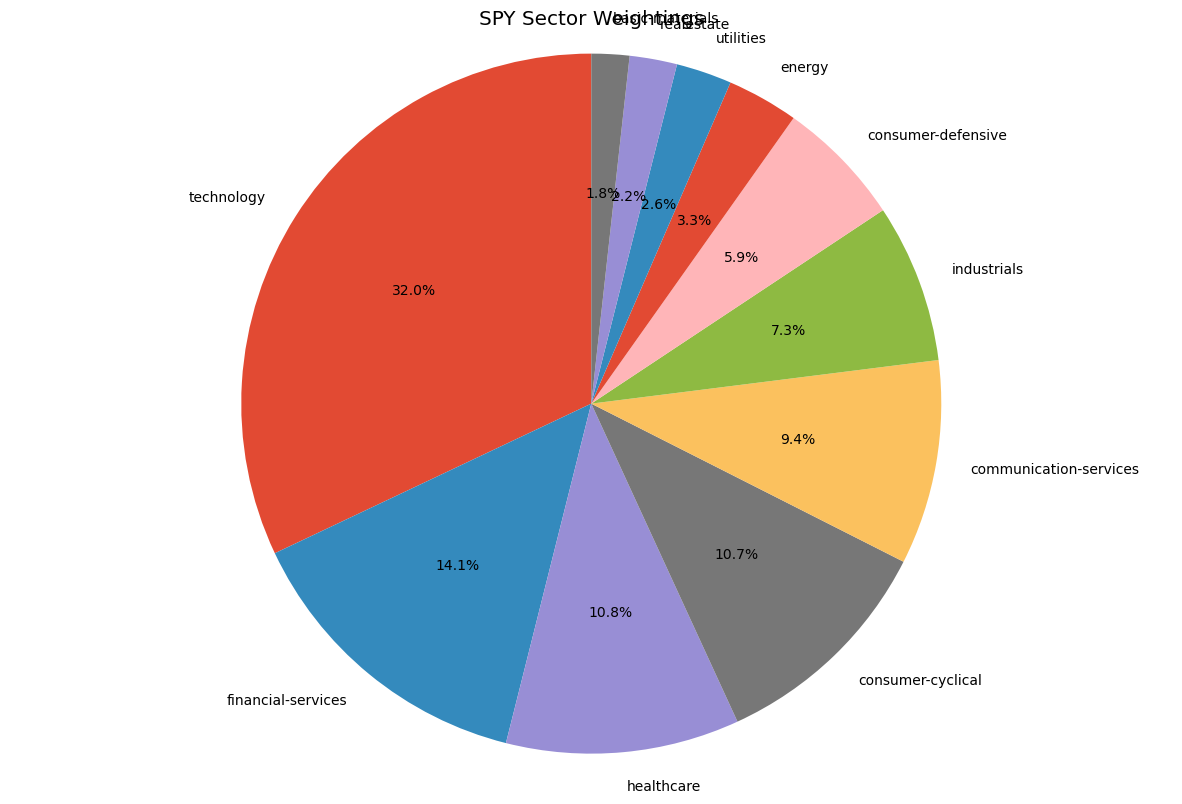


Asset Classes: 0


In [11]:
# Transform fund data (only applicable for SPY ETF)
spy_fund_data = transformer.transform_fund_holdings(spy_ticker_data.fund_data, spy_ticker_id)

# Display the transformed fund data
print("SPY Fund Holdings:")
print(f"Top Holdings: {len(spy_fund_data['holdings'])}")
if spy_fund_data['holdings']:
    # Create DataFrame for easier viewing
    holdings_df = pd.DataFrame([h.model_dump() for h in spy_fund_data['holdings']])
    display(holdings_df.head())
    
    # Plot top holdings
    top_n = min(10, len(holdings_df))
    plt.figure(figsize=(12, 8))
    sorted_holdings = holdings_df.sort_values('weight', ascending=False).head(top_n)
    plt.barh(sorted_holdings['holding_name'], sorted_holdings['weight'])
    plt.title(f'Top {top_n} Holdings in SPY')
    plt.xlabel('Weight (%)')
    plt.tight_layout()
    plt.show()

print(f"\nSector Weightings: {len(spy_fund_data['sectors'])}")
if spy_fund_data['sectors']:
    # Create DataFrame for easier viewing
    sectors_df = pd.DataFrame([s.model_dump() for s in spy_fund_data['sectors']])
    display(sectors_df)
    
    # Plot sector weightings
    plt.figure(figsize=(12, 8))
    sorted_sectors = sectors_df.sort_values('weight', ascending=False)
    plt.pie(sorted_sectors['weight'], labels=sorted_sectors['sector_name'], 
            autopct='%1.1f%%', startangle=90)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
    plt.title('SPY Sector Weightings')
    plt.tight_layout()
    plt.show()

print(f"\nAsset Classes: {len(spy_fund_data['assets'])}")
if spy_fund_data['assets']:
    # Create DataFrame for easier viewing
    assets_df = pd.DataFrame([a.model_dump() for a in spy_fund_data['assets']])
    display(assets_df)

## Test Full Pipeline

Now let's test the full ticker processing pipeline by creating a mock TickerProcessor.

In [12]:
# Create a mock Supabase client
class MockSupabaseTable:
    def __init__(self, name):
        self.name = name
        self.data = []
    
    def select(self, *args):
        return self
    
    def eq(self, field, value):
        return self
    
    def order(self, field, desc=False):
        return self
    
    def limit(self, num):
        return self
    
    def execute(self):
        class Response:
            def __init__(self, data):
                self.data = data
        return Response([])
    
    def upsert(self, data, on_conflict=None):
        self.data.extend(data)
        return self
    
    def update(self, data):
        return self

class MockSupabase:
    def __init__(self):
        self.tables = {}
    
    def table(self, name):
        if name not in self.tables:
            self.tables[name] = MockSupabaseTable(name)
        return self.tables[name]

mock_supabase = MockSupabase()

In [13]:
# Create a mock DataFetcher that returns our test data
class MockDataFetcher(DataFetcher):
    def __init__(self):
        super().__init__()
        self.test_data = {}
    
    def add_test_data(self, symbol, data):
        self.test_data[symbol.upper()] = data
    
    def fetch_ticker_data(self, symbol, exchange, start_date, max_retries=3):
        symbol = symbol.upper()
        if symbol in self.test_data:
            return self.test_data[symbol]
        return None

# Create mock test data instances
mock_fetcher = MockDataFetcher()
mock_fetcher.add_test_data("AAPL", aapl_ticker_data)
mock_fetcher.add_test_data("SPY", spy_ticker_data)

In [14]:
# Create a custom TickerProcessor using our mocks
class TestTickerProcessor(TickerProcessor):
    def __init__(self, supabase_client, data_fetcher):
        # Initialize the parent but replace the data_fetcher
        super().__init__(supabase_client)
        self.data_fetcher = data_fetcher
        # Keep track of what was updated for testing
        self.processed_updates = {}
    
    def process_ticker(self, ticker, config):
        # Call the original method and store results
        updates = super().process_ticker(ticker, config)
        self.processed_updates[ticker["symbol"]] = list(updates)
        return updates

# Create a processor with our mocks
processor = TestTickerProcessor(mock_supabase, mock_fetcher)

In [15]:
# Test processing AAPL
aapl_ticker = {
    "id": aapl_ticker_id,
    "symbol": "AAPL",
    "exchange": "NASDAQ",
    "backfill": False,
    "quote_type": "EQUITY"
}

config = {
    "process_prices": True,
    "process_info": True,
    "process_calendar": True,
    "process_fund_data": False,  # Not needed for AAPL (equity)
    "backfill": False
}

# Process the ticker
aapl_updates = processor.process_ticker(aapl_ticker, config)

print(f"AAPL updates: {aapl_updates}")

{"asctime": "2025-04-13 19:03:55,186", "name": "ticker_processor", "levelname": "INFO", "message": "Processing ticker: AAPL"}
{"asctime": "2025-04-13 19:03:55,187", "name": "data_saver", "levelname": "INFO", "message": "Saved 20 price records for AAPL"}
{"asctime": "2025-04-13 19:03:55,187", "name": "data_saver", "levelname": "INFO", "message": "Saved 3 calendar events for AAPL"}
{"asctime": "2025-04-13 19:03:55,188", "name": "ticker_processor", "levelname": "INFO", "message": "Completed processing AAPL, updated tables: {'calendar_events', 'yh_finance_daily', 'historical_prices', 'tickers'}"}
AAPL updates: {'calendar_events', 'yh_finance_daily', 'historical_prices', 'tickers'}


In [16]:
# Test processing SPY (ETF)
spy_ticker = {
    "id": spy_ticker_id,
    "symbol": "SPY",
    "exchange": "NYSE",
    "backfill": False,
    "quote_type": "ETF"
}

config = {
    "process_prices": True,
    "process_info": True,
    "process_calendar": True,
    "process_fund_data": True,  # Include fund data for ETFs
    "backfill": False
}

# Process the ticker
spy_updates = processor.process_ticker(spy_ticker, config)

print(f"SPY updates: {spy_updates}")

{"asctime": "2025-04-13 19:03:55,205", "name": "ticker_processor", "levelname": "INFO", "message": "Processing ticker: SPY"}
{"asctime": "2025-04-13 19:03:55,206", "name": "data_saver", "levelname": "INFO", "message": "Saved 20 price records for SPY"}
{"asctime": "2025-04-13 19:03:55,206", "name": "data_saver", "levelname": "INFO", "message": "Saved 10 fund holdings for SPY"}
{"asctime": "2025-04-13 19:03:55,206", "name": "data_saver", "levelname": "INFO", "message": "Saved 11 sector weightings for SPY"}
{"asctime": "2025-04-13 19:03:55,207", "name": "ticker_processor", "levelname": "INFO", "message": "Completed processing SPY, updated tables: {'fund_top_holdings', 'fund_sector_weightings', 'tickers', 'yh_finance_daily', 'historical_prices'}"}
SPY updates: {'fund_top_holdings', 'fund_sector_weightings', 'tickers', 'yh_finance_daily', 'historical_prices'}


## Examine Saved Data

Now let's examine what data would have been saved to the database if this wasn't a mock.

In [17]:
# Check what was saved to our mock database
saved_data = {}

for table_name, table in mock_supabase.tables.items():
    if table.data:
        saved_data[table_name] = len(table.data)
        print(f"{table_name}: {len(table.data)} records")

# For example, examine a few records from each table
for table_name, table in mock_supabase.tables.items():
    if table.data:
        print(f"\nSample data from {table_name}:")
        # Take the first record, but limit the output for large objects
        sample = table.data[0]
        if isinstance(sample, dict) and len(sample) > 10:
            # Print just a few keys for brevity
            keys = list(sample.keys())[:5]
            limited_sample = {k: sample[k] for k in keys}
            print(f"{limited_sample} ... and {len(sample) - len(keys)} more fields")
        else:
            pprint(sample)

historical_prices: 40 records
yh_finance_daily: 2 records
calendar_events: 3 records
fund_top_holdings: 10 records
fund_sector_weightings: 11 records

Sample data from historical_prices:
{'close_price': 244.47000122070312,
 'date': '2025-02-18',
 'dividends': 0.0,
 'high_price': 245.17999267578125,
 'low_price': 241.83999633789062,
 'open_price': 244.14999389648438,
 'stock_splits': 0.0,
 'ticker_id': 'aapl-test-id',
 'updated_at': '2025-04-13T19:03:55.187087',
 'volume': 48822500}

Sample data from yh_finance_daily:
{'ticker_id': 'aapl-test-id', 'date': '2025-04-13', 'regular_market_price': 212.69, 'regular_market_change_percent': -0.6121484, 'regular_market_volume': 41207689} ... and 11 more fields

Sample data from calendar_events:
{'date': '2025-02-12',
 'event_type': <DBEventType.DIVIDEND: 'dividend'>,
 'ticker_id': 'aapl-test-id',
 'updated_at': '2025-04-13T19:03:55.187688'}

Sample data from fund_top_holdings:
{'date': '2025-04-13',
 'holding_name': 'Apple Inc',
 'holding_symbol

## Live Testing with Real YFinance API

If you want to test with real API calls, you can use the actual DataFetcher instead of the mock.

In [18]:
# Uncomment to test with real API calls
# Warning: This will make actual API calls to Yahoo Finance

# real_fetcher = DataFetcher()
# processor_with_real_fetcher = TestTickerProcessor(mock_supabase, real_fetcher)

# # Try a symbol not in our test data
# msft_ticker = {
#     "id": "msft-test-id",
#     "symbol": "MSFT",
#     "exchange": "NASDAQ",
#     "backfill": False,
#     "quote_type": "EQUITY"
# }

# msft_updates = processor_with_real_fetcher.process_ticker(msft_ticker, config)
# print(f"MSFT updates: {msft_updates}")

## Test Pipeline Components Individually

You can also test individual components of the pipeline directly.